# Movie data analysis

## Import Packages 

In [1]:
import pandas as pd
import json
import requests
import numpy as np 
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
from wordcloud import WordCloud
import time
import calendar
import pylab as pl
import math

### Task-1 : Choose at least one open web API as your data source (not static datasets). 

##### Movie data analysis
For this assignment I have used a single API TMDb for getting movie data from the TMDb site.  
The API is open source and freely available. The only restriction is that we can send 40 request per second. Data used in this assignment is of one year from 01 Jan 2018 till 20 March 2019. Following is the link of API:
https://developers.themoviedb.org/3/movies/get-movie-details


Setting the API key

In [2]:
api_key = '48f9db4ac53ccc250c47ec0824ce80c9'

### Task-2 : Data Collection

In [3]:
#This function will get the movie id from all the pages for the given date range and call get_movie_details() function 
#to get detailed information using movie ids.
#Input parameter : Date Range
#Output parameter : Data Frame of movie data and credit data

def get_movie_id(start_date,end_date):
    
    # create dataframe 
    headers_mov=['adult', 'backdrop_path', 'genre_ids', 'id','imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path',
                 'release_date', 'title', 'video', 'vote_average', 'vote_count', 'budget', 'revenue','production_companies','production_countries',
                'runtime','spoken_languages','status']
    headers_cre=['id','cast','crew']
    df_mov = pd.DataFrame(columns=headers_mov)
    df_cre = pd.DataFrame(columns=headers_cre)
    page_no = 1
    max_pg_no = 100
    #To put a gap on number of request sent, After every 10 pages there is a sleep of 60sec
    while page_no <= max_pg_no:
        
        if page_no % 10 ==0:
            time.sleep(60)
        #send request to get data for given date range and for given page
        response = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' +  api_key + '&primary_release_date.gte='+start_date+'&primary_release_date.lte='+end_date+'&page='+str(page_no))

        movie_data_json = response.json() # store parsed json response
        #store the number of pages for the above request
        max_pg_no = movie_data_json['total_pages']
        #store the result 
        movies_data = movie_data_json['results']
        #increment the page number
        page_no+=1
        #for each movie we will get the detailed information 
        for movie in movies_data:

            movie_data,credit_data=get_movie_details(movie['id'])
            df_mov.loc[len(df_mov)]=movie_data
            df_cre.loc[len(df_cre)]=credit_data
            
    return df_mov,df_cre


#This function will get the detailed information for each movie. 
#Input parameter : Movie ID
#Output parameter : list of detailed information of movie data and credit data
def get_movie_details(movie_id):
    #request for movie data
    data_mov = requests.get('https://api.themoviedb.org/3/movie/'+ str(movie_id) +'?api_key='+ api_key+'&language=en-US')
    m = data_mov.json()
    #request for credit information of the movie, like cast and crew        
    data_cre = requests.get('https://api.themoviedb.org/3/movie/'+ str(movie_id) +'/credits?api_key='+ api_key+'&language=en-US')
    cre = data_cre.json()
    #Creating 2 list one to store movie data and one for credits
    l=[]
    c=[]
    #Extracting information and storing in list
    try:
        c.append(cre["id"])
        c.append(cre['cast'])
        c.append(cre['crew'])
        l.append(m['adult'])
        l.append(m['backdrop_path'])
        l.append(m['genres'])
        l.append(m['id'])
        l.append(m['imdb_id'])
        l.append(m['original_language'])
        l.append(m['original_title'])
        l.append(m['overview'])
        l.append(m['popularity'])
        l.append(m['poster_path'])
        l.append(m['release_date'])
        l.append(m['title'])
        l.append(m['video'])
        l.append(m['vote_average'])
        l.append(m['vote_count'])
        l.append(m['budget'])
        l.append(m['revenue'])
        l.append(m['production_companies'])
        l.append(m['production_countries'])
        l.append(m['runtime'])
        l.append(m['spoken_languages'])
        l.append(m['status'])
    except AttributeError:
        print('error')
    return l,c

#This function will store the deatiled movie data and credit data in csv files.
#Input : Dataframe and file path

def store_in_csv(mov_data,movie_file,cre_data,credits_file):
    mov_data.to_csv (movie_file, index = None, header=True) 

    cre_data.to_csv (credits_file, index = None, header=True) 


### Task-3 : Parse data and store 

Specify the start and the end date i.e the date range of data you want and give the filenames.

In [4]:
Start_Date = '2018-01-01'
End_Date = '2019-03-20'

print("Data Collection and storage started \n")
#Get movie ids
movies_data,credits_data = get_movie_id(Start_Date, End_Date)

Movies_file_name = 'movies_data.csv'
Credits_file_name = 'credits_data.csv'

#Store data in csv
store_in_csv(movies_data,Movies_file_name,credits_data,Credits_file_name)
print(Movies_file_name, "&",Credits_file_name,"created \n")
print("Data Collection and storage completed \n")

Data Collection and storage started 

movies_data.csv & credits_data.csv created 

Data Collection and storage completed 



### Task-4 : Load and clean data

In [5]:
#Functions used for cleaning the data

#This function will load the movie data. Convert date column to date format and will convert columns containing json string 
#to object
#Returns a dataframe
def load_tmdb_movies(movie_file):
    df = pd.read_csv(movie_file)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date()) #Convert to date format
    json_columns = ['genre_ids', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] =  '"' + df[column] + '"'
        df[column] = df[column].apply(json.dumps)
        df[column] = df[column].apply(json.loads)
    return df

#This function will load the credits data. Convert columns containing json string to object.
#Returns a dataframe
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] =  '"' + df[column] + '"'
        df[column] = df[column].apply(json.dumps)
        df[column] = df[column].apply(json.loads)
    return df

#This function flattens all the json columns 
def convert_json_to_column(movies_credits):
    Cols = ['id','title','release_date','popularity','vote_average','vote_count','budget','revenue', 'runtime','status']
    tmdb_movies = movies_credits[Cols]    
    tmdb_movies['release_year'] = tmdb_movies['release_date'].apply(lambda x: x.year)    
    tmdb_movies['release_month'] = tmdb_movies['release_date'].apply(lambda x: x.month)    
    tmdb_movies['country'] = movies_credits['production_countries'].apply(lambda x: get_name(x, [0, 'name']))
    tmdb_movies['language_code'] = movies_credits['spoken_languages'].apply(lambda x: get_name(x, [0, 'iso_639_1']))
    tmdb_movies['director_name'] = movies_credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = movies_credits['cast'].apply(lambda x: get_name(x, [1, 'name']))
    tmdb_movies['actor_2_name'] = movies_credits['cast'].apply(lambda x: get_name(x, [2, 'name']))
    tmdb_movies['actor_3_name'] = movies_credits['cast'].apply(lambda x: get_name(x, [3, 'name']))
    tmdb_movies['genres'] = movies_credits['genre_ids'].apply(get_genre_names)
    tmdb_movies = pd.concat([tmdb_movies,get_genre(movies_credits['genre_ids'])],axis=1)
    
    return tmdb_movies

#As there are multiple columns in json format, to flatten the data following functions are used.

#This function gets the genre names from json string and returns them in pipe separated format.
def get_genre_names(genres):
    #Cleans json string by replacing single quotes with double quotes.
    genres = clean_json(genres)   
    #Converts json string to object
    genres = json.loads(genres)
    
    return '|'.join([x['name'] for x in genres])

#This function gets the data specified in column_name from json string.
def get_name(json_string, column_name):
    
    result = json_string
    
    if (isinstance(result, str)):
        result = clean_json(result) 
        
        result = json.loads(result)    
            
    try:
        for idx in column_name:            
            result = result[idx]
        return result
    except IndexError or KeyError or TypeError:
        return pd.np.nan


#This function is used to clean json string so that it can be converted in object. 
def clean_json(json_data):    
    
    #Rules to clean the json and add double quotes and single quotes wherever necessary.
    json_data = json_data.replace("\"","'")
    json_data = json_data.replace("{'","{\"")
    json_data = json_data.replace("':","\":")
    json_data = json_data.replace(", '",", \"")
    json_data = json_data.replace(": '",": \"")
    json_data = json_data.replace("',","\",")
    json_data = json_data.replace("'}","\"}")  
    json_data1 = re.findall(r"(?i)([a-z]+), \"(?i)([a-z]+)", json_data)    
    for i in range(len(json_data1)):        
        json_data = re.sub(r"(?i)([a-z]+), \"(?i)([a-z]+)", json_data1[i][0]+", \'"+json_data1[i][1], json_data, 1)        
    json_data1 = re.findall(r"(?i)([a-z]+): \"(?i)([a-z]+)", json_data)    
    for i in range(len(json_data1)):        
        json_data = re.sub(r"(?i)([a-z]+): \"(?i)([a-z]+)", json_data1[i][0]+": \'"+json_data1[i][1], json_data, 1)    
    json_data = re.sub(r"\bNone\b", "\"None\"", json_data)   
    json_data = re.sub(r"\\", "/", json_data)
    json_data = re.sub(r'^\'|\'$', '', json_data)    
    
    return json_data

#This function converts the large number in budget and revenue column into human readable format like millions and billions.
def millify(n):
    millnames = ['',' K',' M',' B',' T']
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))

    return '${:.0f}{}'.format(n / 10**(3 * millidx), millnames[millidx])

#This function reads the json string and wherever it gets job=='Director' it will return the name as director name.
def get_director(crew_data):      
    crew_data = clean_json(crew_data)  #Clean json string 
    crew_data = json.loads(crew_data)  #Convert json string to object
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return get_name(directors, [0])

#This function will create a column for each genre and will store 0,1 value
# 0 - Not present / Not having this genre
# 1 - Present / Having this genre
def get_genre(genres):
    genres = [get_genre_names(genre) for genre in genres]
    df= pd.DataFrame(genres,columns=["Genre"])
    
    genres_list = set()
    #get unique list of genres
    for genre in df['Genre'].str.split('|'):
        genres_list = set().union(genre, genres_list)
    genres_list = list(genres_list)
    genres_list.remove('')
    df_genres = pd.DataFrame()
    #create column for each genre
    for genre in genres_list:
        df_genres[genre] = df['Genre'].str.contains(genre).apply(lambda x:1 if x else 0)
    
    return df_genres


###### Load movie data

In [6]:
movies = load_tmdb_movies("movies_data.csv")
movies.head()

,adult,backdrop_path,genre_ids,id,imdb_id,original_language,original_title,overview,popularity,poster_path,...,video,vote_average,vote_count,budget,revenue,production_companies,production_countries,runtime,spoken_languages,status
0,False,/9ywA15OAiwjSTvg3cBs9B7kOCBF.jpg,"""[{'id': 18, 'name': 'Drama'}, {'id': 10749, '...",337167,tt4477536,en,Fifty Shades Freed,Believing they have left behind shadowy figure...,51.965,/jjPJ4s3DWZZvI4vw8Xfi4Vqa1Q8.jpg,...,False,6.1,3344,55000000,368307760,"""[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dK...","""[{'iso_3166_1': 'US', 'name': 'United States ...",105.0,"""[{'iso_639_1': 'en', 'name': 'English'}]""",Released
1,False,/s3FDBLH4qc1IcjexB05Qvbn3wxO.jpg,"""[{'id': 28, 'name': 'Action'}, {'id': 53, 'na...",449443,tt1259528,en,Den of Thieves,A gritty crime saga which follows the lives of...,22.904,/AfybH6GbGFw1F9bcETe2yu25mIE.jpg,...,False,6.5,1136,30000000,80509622,"""[{'id': 2995, 'logo_path': None, 'name': 'Atm...","""[{'iso_3166_1': 'US', 'name': 'United States ...",140.0,"""[{'iso_639_1': 'en', 'name': 'English'}]""",Released
2,False,/5X7SmFFkaIpJqeApaxelvFirnNF.jpg,"""[{'id': 28, 'name': 'Action'}, {'id': 53, 'na...",460059,tt6340604,en,Burn Out,"Tony, a promising young motorcycle racer, is f...",21.535,/3LeFOvzjZuIC7cQiXDeSIy1ym7a.jpg,...,False,6.6,61,0,0,"""[{'id': 3416, 'logo_path': None, 'name': 'Som...","""[{'iso_3166_1': 'FR', 'name': 'France'}]""",107.0,"""[{'iso_639_1': 'fr', 'name': 'Français'}]""",Released
3,False,/bvbyidkMaBls1LTaIWYY6UmYTaL.jpg,"""[{'id': 28, 'name': 'Action'}, {'id': 878, 'n...",336843,tt4500922,en,Maze Runner: The Death Cure,Thomas leads his group of escaped Gladers on t...,20.526,/2zYfzA3TBwrMC8tfFbpiTLODde0.jpg,...,False,7.1,3618,62000000,284881603,"""[{'id': 3672, 'logo_path': '/5VWXJgYYrJZUE0hi...","""[{'iso_3166_1': 'US', 'name': 'United States ...",144.0,"""[{'iso_639_1': 'en', 'name': 'English'}]""",Released
4,False,/W8V8d9bjLZURgEGbIB5TC70yaj.jpg,"""[{'id': 28, 'name': 'Action'}, {'id': 53, 'na...",401478,tt3807900,en,Death Race: Beyond Anarchy,Black Ops specialist Connor Gibson infiltrates...,15.673,/1PrlKvPUbDQAqFQBCyyt68hLLl.jpg,...,False,5.5,82,0,0,"""[{'id': 2365, 'logo_path': None, 'name': 'Cap...","""[{'iso_3166_1': 'US', 'name': 'United States ...",111.0,"""[{'iso_639_1': 'fr', 'name': 'Français'}, {'i...",Released


###### Load credits data

In [7]:
credits = load_tmdb_credits("credits_data.csv")
credits.head()

,id,cast,crew
0,337167,"""[{'cast_id': 1, 'character': 'Anastasia Steel...","""[{'credit_id': '56f86694c3a36816e8007742', 'd..."
1,449443,"""[{'cast_id': 0, 'character': 'Nick Flanagan',...","""[{'credit_id': '58f9304ac3a368394900115a', 'd..."
2,460059,"""[{'cast_id': 4, 'character': 'Tony', 'credit_...","""[{'credit_id': '593036bf92514166f9000bb5', 'd..."
3,336843,"""[{'cast_id': 0, 'character': 'Thomas', 'credi...","""[{'credit_id': '585fc55f92514115cf01d6a5', 'd..."
4,401478,"""[{'cast_id': 75, 'character': 'Goldberg', 'cr...","""[{'credit_id': '575a72de92514128a3000c98', 'd..."


Merge the above 2 data frames 
First will check in both data frames every row is about the same movie

In [8]:
(credits['id']==movies['id']).describe()

count     16795
unique        1
top        True
freq      16795
Name: id, dtype: object

This tells us that every row in the credits data frame has the same movie id as the same row in the movies data frame.
Next step is to merge the 2 data frames

In [9]:
movies_credits = pd.merge(movies, credits, on='id', how='inner')
movies_credits.head()

,adult,backdrop_path,genre_ids,id,imdb_id,original_language,original_title,overview,popularity,poster_path,...,vote_count,budget,revenue,production_companies,production_countries,runtime,spoken_languages,status,cast,crew
0,False,/9ywA15OAiwjSTvg3cBs9B7kOCBF.jpg,"""[{'id': 18, 'name': 'Drama'}, {'id': 10749, '...",337167,tt4477536,en,Fifty Shades Freed,Believing they have left behind shadowy figure...,51.965,/jjPJ4s3DWZZvI4vw8Xfi4Vqa1Q8.jpg,...,3344,55000000,368307760,"""[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dK...","""[{'iso_3166_1': 'US', 'name': 'United States ...",105.0,"""[{'iso_639_1': 'en', 'name': 'English'}]""",Released,"""[{'cast_id': 1, 'character': 'Anastasia Steel...","""[{'credit_id': '56f86694c3a36816e8007742', 'd..."
1,False,/s3FDBLH4qc1IcjexB05Qvbn3wxO.jpg,"""[{'id': 28, 'name': 'Action'}, {'id': 53, 'na...",449443,tt1259528,en,Den of Thieves,A gritty crime saga which follows the lives of...,22.904,/AfybH6GbGFw1F9bcETe2yu25mIE.jpg,...,1136,30000000,80509622,"""[{'id': 2995, 'logo_path': None, 'name': 'Atm...","""[{'iso_3166_1': 'US', 'name': 'United States ...",140.0,"""[{'iso_639_1': 'en', 'name': 'English'}]""",Released,"""[{'cast_id': 0, 'character': 'Nick Flanagan',...","""[{'credit_id': '58f9304ac3a368394900115a', 'd..."
2,False,/5X7SmFFkaIpJqeApaxelvFirnNF.jpg,"""[{'id': 28, 'name': 'Action'}, {'id': 53, 'na...",460059,tt6340604,en,Burn Out,"Tony, a promising young motorcycle racer, is f...",21.535,/3LeFOvzjZuIC7cQiXDeSIy1ym7a.jpg,...,61,0,0,"""[{'id': 3416, 'logo_path': None, 'name': 'Som...","""[{'iso_3166_1': 'FR', 'name': 'France'}]""",107.0,"""[{'iso_639_1': 'fr', 'name': 'Français'}]""",Released,"""[{'cast_id': 4, 'character': 'Tony', 'credit_...","""[{'credit_id': '593036bf92514166f9000bb5', 'd..."
3,False,/bvbyidkMaBls1LTaIWYY6UmYTaL.jpg,"""[{'id': 28, 'name': 'Action'}, {'id': 878, 'n...",336843,tt4500922,en,Maze Runner: The Death Cure,Thomas leads his group of escaped Gladers on t...,20.526,/2zYfzA3TBwrMC8tfFbpiTLODde0.jpg,...,3618,62000000,284881603,"""[{'id': 3672, 'logo_path': '/5VWXJgYYrJZUE0hi...","""[{'iso_3166_1': 'US', 'name': 'United States ...",144.0,"""[{'iso_639_1': 'en', 'name': 'English'}]""",Released,"""[{'cast_id': 0, 'character': 'Thomas', 'credi...","""[{'credit_id': '585fc55f92514115cf01d6a5', 'd..."
4,False,/W8V8d9bjLZURgEGbIB5TC70yaj.jpg,"""[{'id': 28, 'name': 'Action'}, {'id': 53, 'na...",401478,tt3807900,en,Death Race: Beyond Anarchy,Black Ops specialist Connor Gibson infiltrates...,15.673,/1PrlKvPUbDQAqFQBCyyt68hLLl.jpg,...,82,0,0,"""[{'id': 2365, 'logo_path': None, 'name': 'Cap...","""[{'iso_3166_1': 'US', 'name': 'United States ...",111.0,"""[{'iso_639_1': 'fr', 'name': 'Français'}, {'i...",Released,"""[{'cast_id': 75, 'character': 'Goldberg', 'cr...","""[{'credit_id': '575a72de92514128a3000c98', 'd..."


There are few columns like genre_ids, production_companies, production_countries, spoken_languages, cast and crew in json format so need to flatten that which would be useful for futher analysis

In [10]:
tmdb_movies_data = convert_json_to_column(movies_credits)
tmdb_movies_data.head()

,id,title,release_date,popularity,vote_average,vote_count,budget,revenue,runtime,status,...,Crime,Action,Thriller,Music,Science Fiction,Fantasy,Documentary,History,War,Drama
0,337167,Fifty Shades Freed,2018-01-17,51.965,6.1,3344,55000000,368307760,105.0,Released,...,0,0,0,0,0,0,0,0,0,1
1,449443,Den of Thieves,2018-01-18,22.904,6.5,1136,30000000,80509622,140.0,Released,...,1,1,1,0,0,0,0,0,0,0
2,460059,Burn Out,2018-01-03,21.535,6.6,61,0,0,107.0,Released,...,0,1,1,0,0,0,0,0,0,0
3,336843,Maze Runner: The Death Cure,2018-01-10,20.526,7.1,3618,62000000,284881603,144.0,Released,...,0,1,0,0,1,0,0,0,0,0
4,401478,Death Race: Beyond Anarchy,2018-01-30,15.673,5.5,82,0,0,111.0,Released,...,0,1,1,0,0,0,0,0,0,0


Rename few columns

In [11]:
tmdb_movies_data = tmdb_movies_data.rename(index=str, columns={"id": "TMDB_id", "title": "movie_title"})

Check for any Non Numeric data in TMDB_id

In [12]:
print (tmdb_movies_data[pd.to_numeric(tmdb_movies_data['TMDB_id'], errors='coerce').isnull()])

Empty DataFrame
Columns: [TMDB_id, movie_title, release_date, popularity, vote_average, vote_count, budget, revenue, runtime, status, release_year, release_month, country, language_code, director_name, actor_1_name, actor_2_name, actor_3_name, genres, Animation, Mystery, Western, TV Movie, Family, Romance, Horror, Comedy, Adventure, Crime, Action, Thriller, Music, Science Fiction, Fantasy, Documentary, History, War, Drama]
Index: []

[0 rows x 38 columns]


There is no non numeric data in TMDB_id
If any data is present below code will drop that row

In [13]:
tmdb_movies_data["TMDB_id"] =pd.to_numeric(tmdb_movies_data['TMDB_id'], errors='coerce',downcast="integer")
tmdb_movies_data.dropna(subset=["TMDB_id"],inplace=True)


Fill all the nan values in numeric column with 0 and for string column with blank

In [14]:
tmdb_movies_data[['popularity', 'vote_average','vote_count', 'budget', 'revenue', 'runtime','Romance', 'Science Fiction', 'History', 'Western', 'Horror', 'Animation', 'Action', 'Music', 'TV Movie', 'Comedy', 'Drama', 'War', 'Fantasy', 'Thriller', 'Family', 'Mystery', 'Crime', 'Documentary', 'Adventure']].replace(np.nan, 0, regex=True,inplace=True)


tmdb_movies_data[['movie_title', 'status','country', 'language_code', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'genres']].replace(np.nan, ' ', regex=True,inplace=True)


In [15]:
tmdb_movies_data[['popularity','vote_average','vote_count','budget','revenue','runtime']].describe().round()

,popularity,vote_average,vote_count,budget,revenue,runtime
count,21279.0,21279.0,21279.0,21279.0,2.127900e+04,16211.0
mean,2.0,2.0,16.0,506889.0,1.352896e+06,67.0
std,6.0,3.0,214.0,9264659.0,3.001640e+07,69.0
min,0.0,0.0,0.0,0.0,0.000000e+00,1.0
25%,1.0,0.0,0.0,0.0,0.000000e+00,17.0
50%,1.0,0.0,0.0,0.0,0.000000e+00,78.0
75%,2.0,5.0,1.0,0.0,0.000000e+00,96.0
max,378.0,10.0,12190.0,944000000.0,2.046240e+09,5798.0


There is a column called language code which contains the iso-639-1 language codes. 
To get the language name from language code I have used iso639-1_language_code.csv file which contains language and its code.
Using this file language codes are replaced with the corresponding language names.

In [16]:
df_language_code = pd.read_csv('iso639-1_language_code.csv')

In [17]:
tmdb_movies_data['language_code'] = tmdb_movies_data['language_code'].map(df_language_code.set_index('Code')['Language']).fillna(tmdb_movies_data['language_code'])
tmdb_movies_data = tmdb_movies_data.rename(index=str, columns={"language_code": "language"}) # rename the column

Check for null values

In [18]:
tmdb_movies_data.isnull().sum()

TMDB_id                0
movie_title            0
release_date           1
popularity             0
vote_average           0
vote_count             0
budget                 0
revenue                0
runtime             5068
status                 0
release_year           1
release_month          1
country             8214
language            7341
director_name       2457
actor_1_name        8641
actor_2_name       10065
actor_3_name       11498
genres                 0
Animation              0
Mystery                0
Western                0
TV Movie               0
Family                 0
Romance                0
Horror                 0
Comedy                 0
Adventure              0
Crime                  0
Action                 0
Thriller               0
Music                  0
Science Fiction        0
Fantasy                0
Documentary            0
History                0
War                    0
Drama                  0
dtype: int64

There are many null values in runtime I have used interpolate method to fill those missing value

In [19]:
tmdb_movies_data['runtime'] = tmdb_movies_data['runtime'].interpolate(method ='linear', limit_direction ='both')


In [20]:
tmdb_movies_data.isnull().sum()

TMDB_id                0
movie_title            0
release_date           1
popularity             0
vote_average           0
vote_count             0
budget                 0
revenue                0
runtime                0
status                 0
release_year           1
release_month          1
country             8214
language            7341
director_name       2457
actor_1_name        8641
actor_2_name       10065
actor_3_name       11498
genres                 0
Animation              0
Mystery                0
Western                0
TV Movie               0
Family                 0
Romance                0
Horror                 0
Comedy                 0
Adventure              0
Crime                  0
Action                 0
Thriller               0
Music                  0
Science Fiction        0
Fantasy                0
Documentary            0
History                0
War                    0
Drama                  0
dtype: int64

### Task 5: Analyse and summarise the cleaned dataset

##### Country Analysis

Analyse number of movies in each country and display top 10 countries with highest number of movies

In [21]:
#Extract number of films per country
df_countries = tmdb_movies_data['release_year'].groupby(tmdb_movies_data['country']).count()
df_countries = df_countries.reset_index()
df_countries.rename(columns ={'release_year':'count'}, inplace = True)
df_countries = df_countries.sort_values('count', ascending = False)
df_countries.reset_index(drop=True, inplace = True)


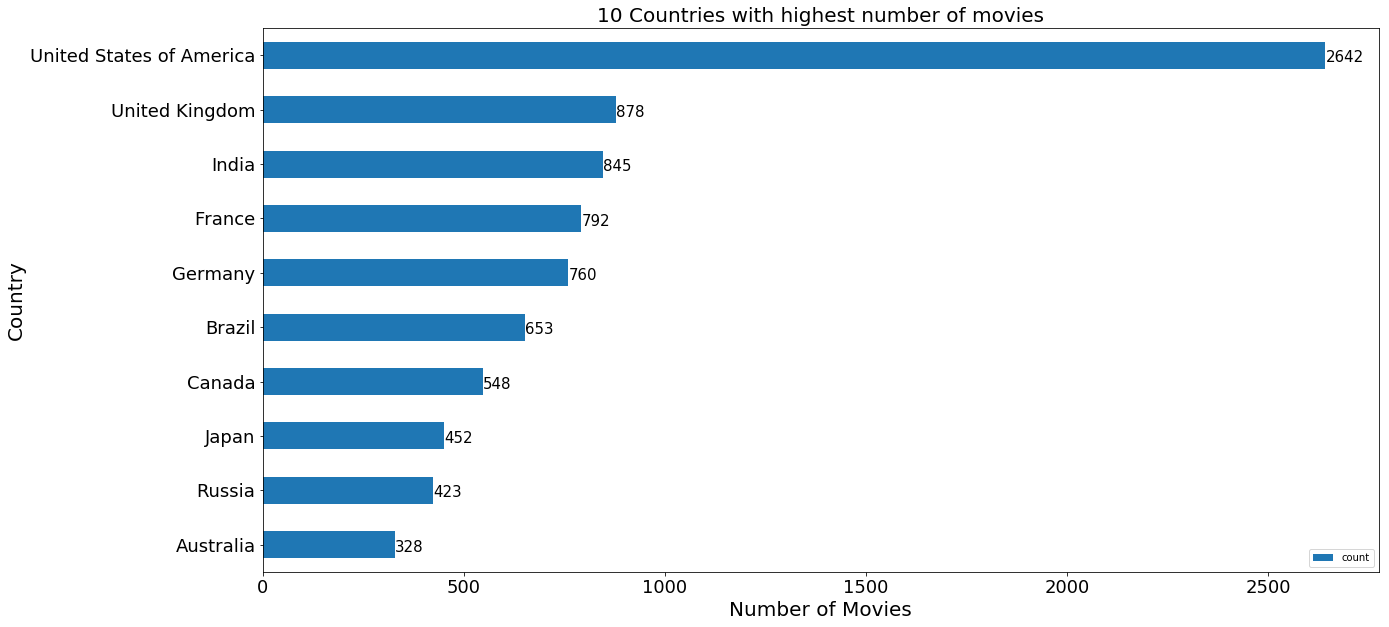

In [22]:
ax = df_countries.head(10).plot(kind='barh', x='country',y='count',figsize=(20, 10), legend=True, fontsize=18)
ax.set_title("10 Countries with highest number of movies",fontsize=20)
ax.set_xlabel("Number of Movies", fontsize=20)
ax.set_ylabel("Country", fontsize=20)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()), 2)), fontsize=15)

# invert for largest on top 
ax.invert_yaxis()
plt.show()

The above bar chart shows the top 10 countries which have the highest number of movies produced. As can be seen, United States has the highest production of movies at 2642 which is much larger than the country at second position.

##### Language Analysis

Number of movies made in each language and display the top 10 languages with max number of movies

In [23]:
#Extracting values grouping by language and finding the unique language in that group
df_language = tmdb_movies_data.groupby(by='language', as_index=False).agg({'TMDB_id': pd.Series.nunique})
df_language['language'].replace('', np.nan, inplace=True)
df_language.dropna(subset=['language'], inplace=True)
df_language.rename(columns ={'TMDB_id':'count'}, inplace = True)
df_language = df_language.sort_values(by='count', ascending=False).head(10)
df_countries.reset_index(drop=True, inplace = True)

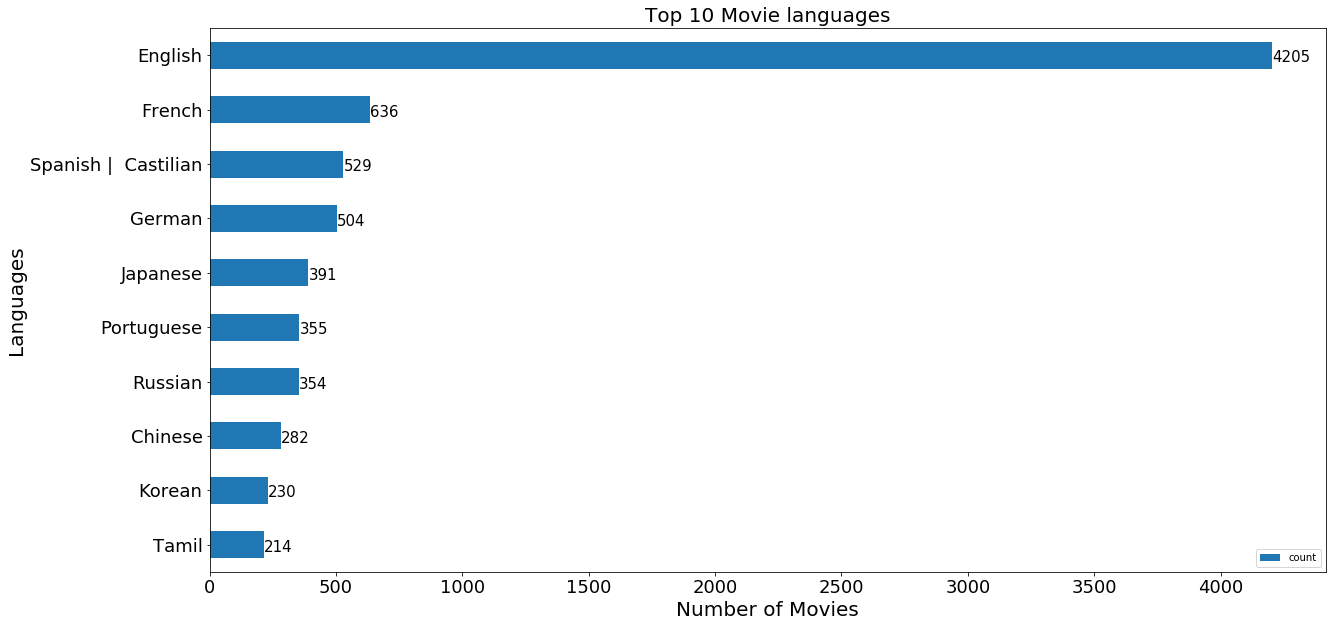

In [24]:
ax = df_language.head(10).plot(kind='barh', x='language',y='count',figsize=(20, 10), legend=True, fontsize=18)
ax.set_title("Top 10 Movie languages",fontsize=20)
ax.set_xlabel("Number of Movies", fontsize=20)
ax.set_ylabel("Languages", fontsize=20)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()), 2)), fontsize=15)

# invert for largest on top 
ax.invert_yaxis()
plt.show()

The above bar chart shows top 10 languages with highest number of movies made. As many movies are made in USA and UK highest number of movies are made in English language. 

#### Most popular movie in the data base

Most popular movie is the movie which is having highest popularity value

In [25]:
#Sorting by popularity and selecting the top 10
df_popularity = tmdb_movies_data[['movie_title','popularity']].sort_values(by=['popularity'], ascending=False).head(10)
df_popularity

,movie_title,popularity
10992,How to Train Your Dragon: The Hidden World,378.308
13100,Captain Marvel,366.817
9681,Master Z: Ip Man Legacy,324.002
13101,Triple Frontier,197.817
9682,Aquaman,181.836
10993,Alita: Battle Angel,161.729
9683,Spider-Man: Into the Spider-Verse,159.749
16868,Avengers: Infinity War,139.940
10994,Fate/stay night: Heaven’s Feel II. lost butterfly,115.960
13102,Captive State,115.067


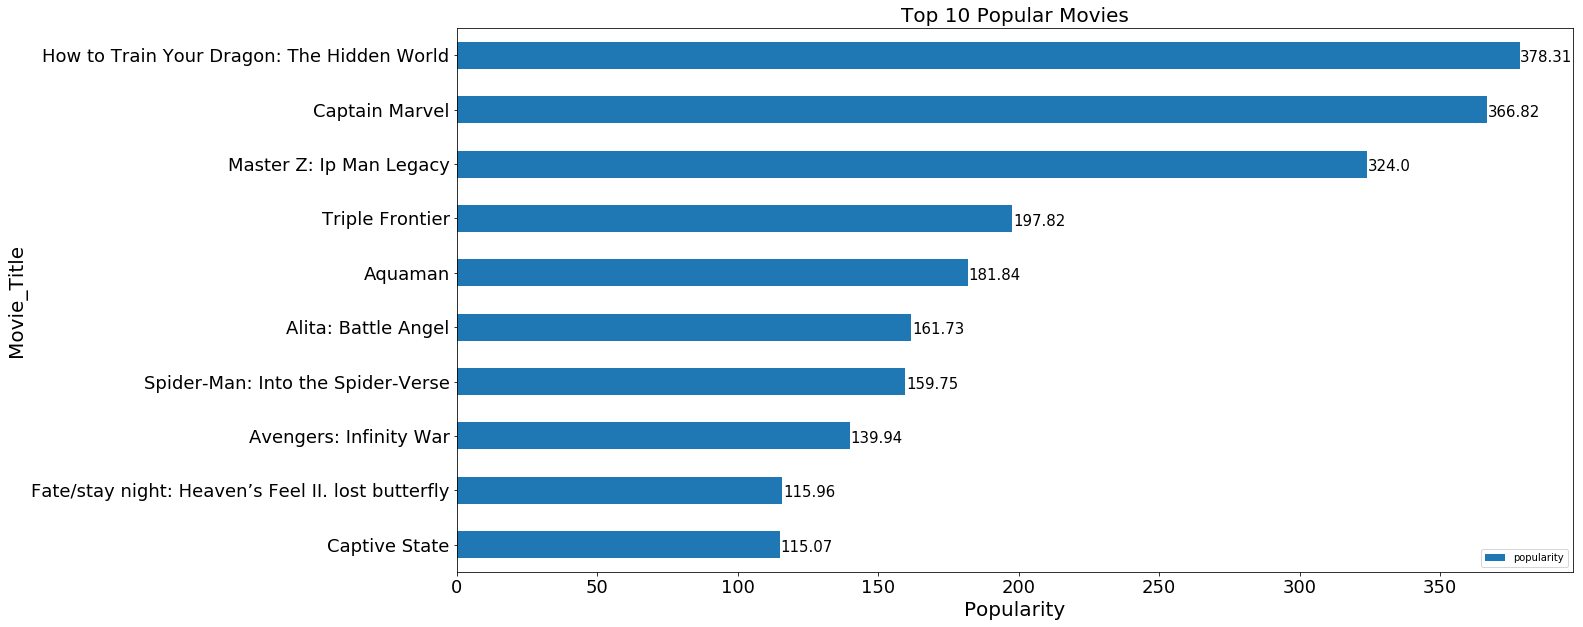

In [26]:
ax = df_popularity.plot(kind='barh', y='popularity',x='movie_title',figsize=(20, 10), legend=True, fontsize=18)
ax.set_title("Top 10 Popular Movies",fontsize=20)
ax.set_xlabel("Popularity", fontsize=20)
ax.set_ylabel("Movie_Title", fontsize=20)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()), 2)), fontsize=15)

# invert for largest on top 
ax.invert_yaxis()
plt.show()

The bar graph shows the top 10 popular movies and their popularity. The most popular movie last year was 'How to Train Your Dragon: The Hidden World' with a popularity of 378.31. 

Based on the Country analysis for the top 3 countrys popular movies are found. 

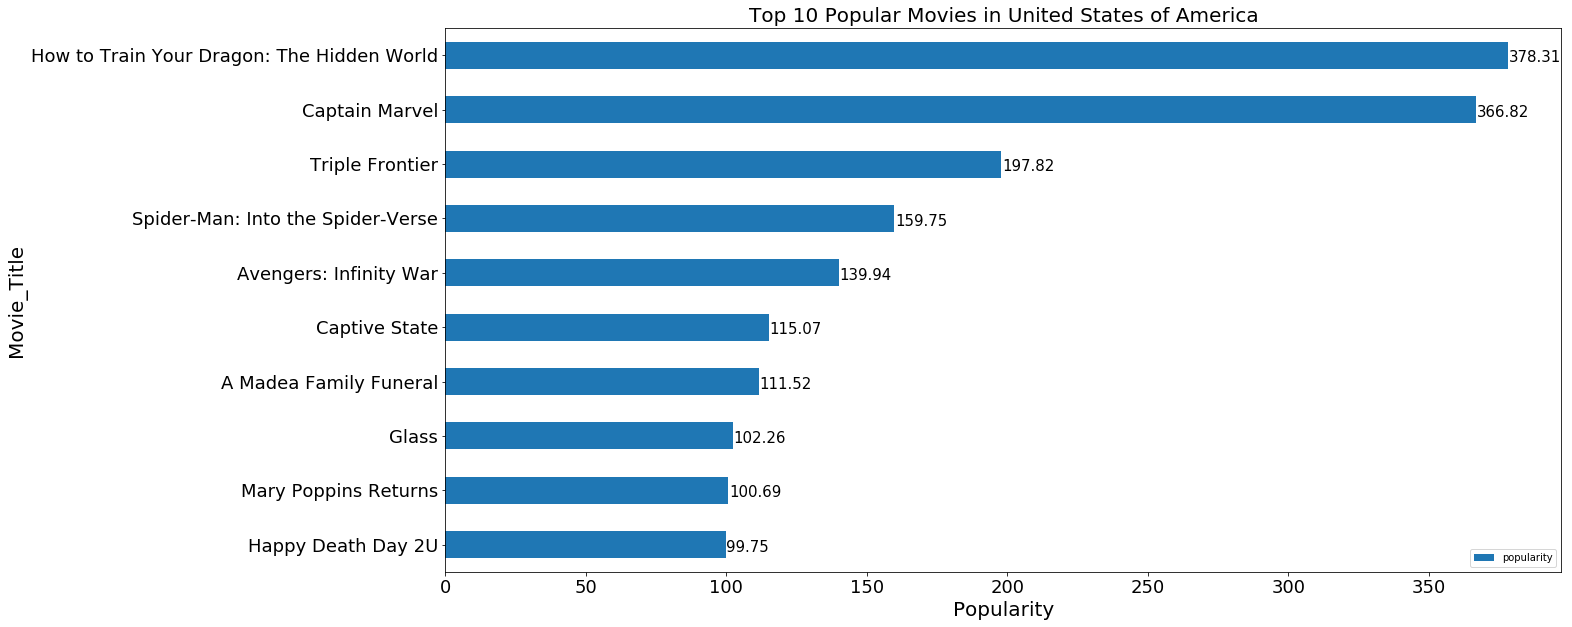

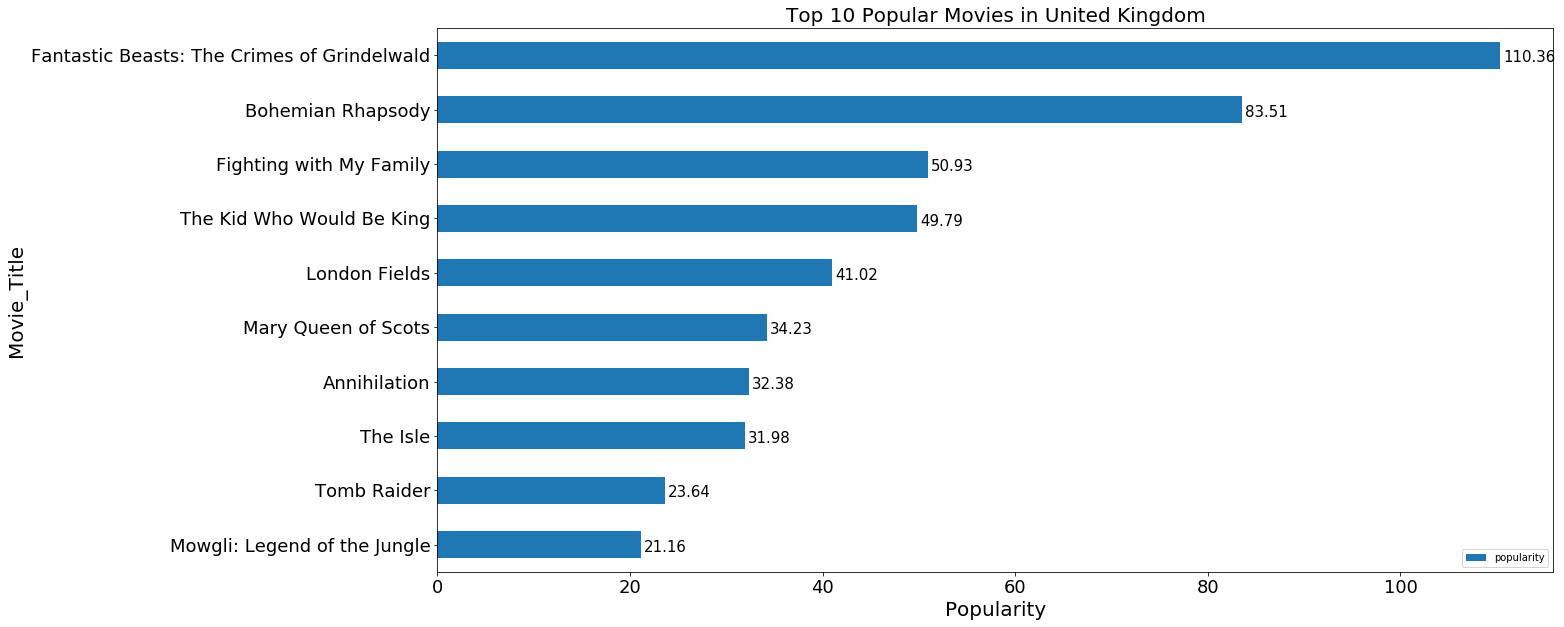

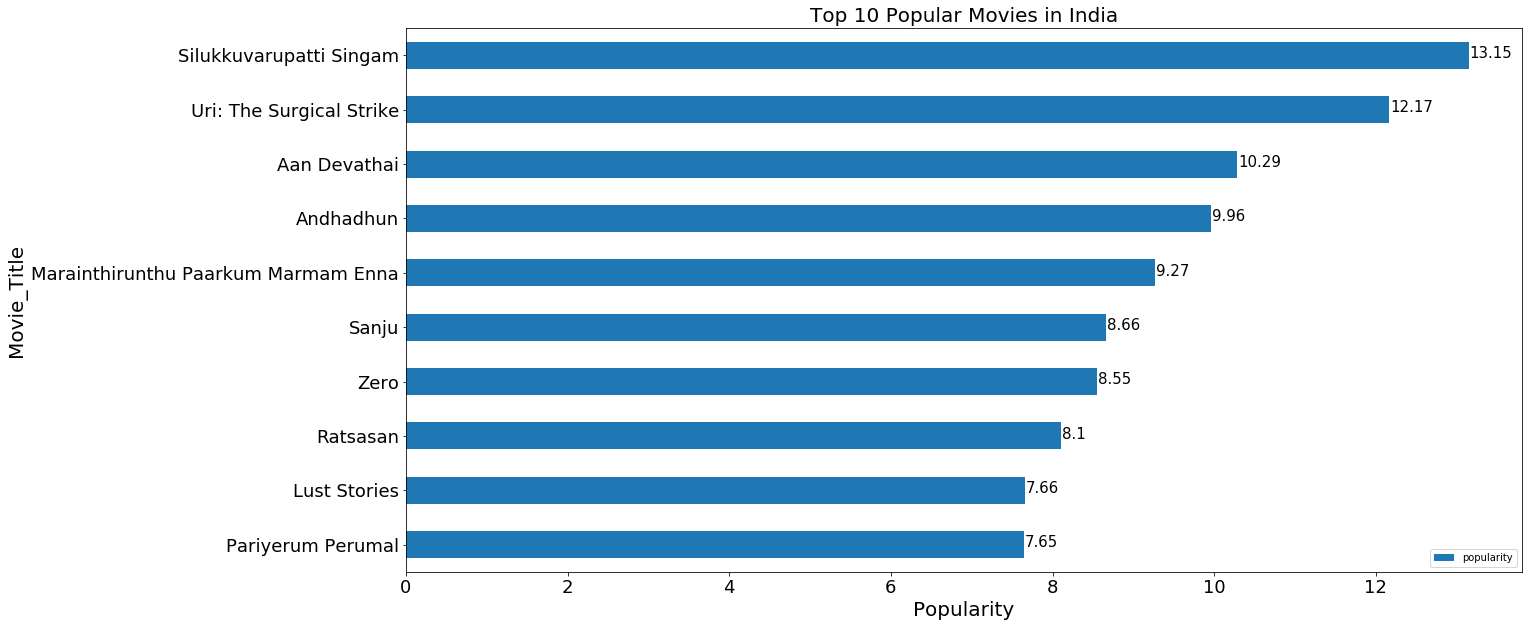

In [27]:
#filtering the data based on the country name and creating data frame for each country and plotting each data frame
df_popularity_country1 = tmdb_movies_data[['movie_title','popularity']].loc[tmdb_movies_data['country'].isin([df_countries['country'][0]])].sort_values(by=['popularity'], ascending=False).head(10)
df_popularity_country2 = tmdb_movies_data[['movie_title','popularity']].loc[tmdb_movies_data['country'].isin([df_countries['country'][1]])].sort_values(by=['popularity'], ascending=False).head(10)
df_popularity_country3 = tmdb_movies_data[['movie_title','popularity']].loc[tmdb_movies_data['country'].isin([df_countries['country'][2]])].sort_values(by=['popularity'], ascending=False).head(10)

#Country-1
ax = df_popularity_country1.plot(kind='barh', y='popularity',x='movie_title',figsize=(20, 10), legend=True, fontsize=18)
ax.set_title("Top 10 Popular Movies in "+df_countries['country'][0],fontsize=20)
ax.set_xlabel("Popularity", fontsize=20)
ax.set_ylabel("Movie_Title", fontsize=20)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()), 2)), fontsize=15)

# invert for largest on top 
ax.invert_yaxis()
plt.show()

#Country-2
ax = df_popularity_country2.plot(kind='barh', y='popularity',x='movie_title',figsize=(20, 10), legend=True, fontsize=18)
ax.set_title("Top 10 Popular Movies in "+df_countries['country'][1],fontsize=20)
ax.set_xlabel("Popularity", fontsize=20)
ax.set_ylabel("Movie_Title", fontsize=20)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()), 2)), fontsize=15)

# invert for largest on top 
ax.invert_yaxis()
plt.show()

#Country-3
ax = df_popularity_country3.plot(kind='barh', y='popularity',x='movie_title',figsize=(20, 10), legend=True, fontsize=18)
ax.set_title("Top 10 Popular Movies in "+df_countries['country'][2],fontsize=20)
ax.set_xlabel("Popularity", fontsize=20)
ax.set_ylabel("Movie_Title", fontsize=20)

for i in ax.patches:
    ax.text(i.get_width()+.01, i.get_y()+.30, \
            str(round((i.get_width()), 2)), fontsize=15)

# invert for largest on top 
ax.invert_yaxis()
plt.show()

Next I have found the 10 most popular movies in the top 3 countries with highest production of movies from the first analysis. The first country United States of America has the most popular movie 'How to Train Your Dragon: The Hidden World'. The second country United Kingdom has 'Fantastic Beasts: The Crimes of Grindlewald' as the most popular movie. And in the third country India, 'Silukkuvarupatti Singam' is the most popular movie.

##### Genre analysis

Finding the most popular genre from the entire database.
The genre to which most movies belong.

In [28]:
genres_list = set()
for genre in tmdb_movies_data['genres'].str.split('|'):
    genres_list = set().union(genre, genres_list)
genres_list = list(genres_list)
genres_list.remove('')
genre_count = {}
for genre in genres_list:
    genre_count[genre] = tmdb_movies_data[genre].values.sum()

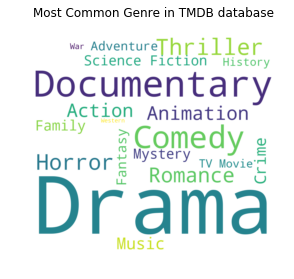

In [29]:
wordcloud = WordCloud(max_font_size=550,width=1000,height=900, background_color="white",max_words=100).generate_from_frequencies(genre_count)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Genre in TMDB database\n")
plt.show()

The above word cloud shows the most common genres in TMDb Database. The most common genre of films last year was Drama followed by Documentary and Comedy.

Popular genres for the top 3 countries are found

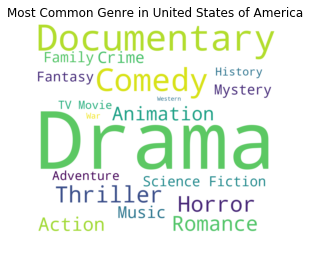

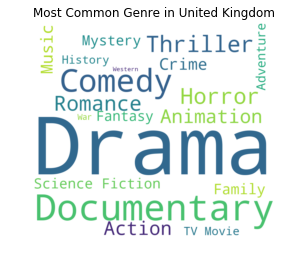

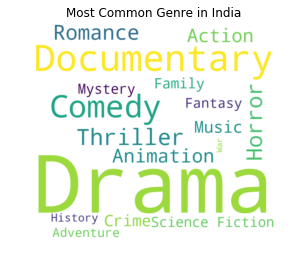

In [30]:
def draw_wordcloud(index):
    genres_list = set()
    a = tmdb_movies_data[['genres']].loc[tmdb_movies_data['country'].isin([df_countries['country'][index]])]
    for genre in a['genres'].str.split('|'):
        genres_list = set().union(genre, genres_list)
    genres_list = list(genres_list)
    genres_list.remove('')
    genre_count = {}
    for genre in genres_list:
        genre_count[genre] = tmdb_movies_data[genre].values.sum()

    wordcloud = WordCloud(max_font_size=550,width=1000,height=900, background_color="white",max_words=100).generate_from_frequencies(genre_count)
    return wordcloud

for ind in range(3):
    wordcloud = draw_wordcloud(ind)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Most Common Genre in "+df_countries['country'][ind])
    plt.show()

Following the general popular genre over the whole database, the popular genres for the first 3 countries are found. It is seen that Drama is the most common genre in all three countries. The first 3-4 most common genres i.e Drama, Documentary, Comedy and Thriller are same for all the three countries. 

Calculating mean value for votes_average, budget, revenue and profit per genre 

In [31]:
mean_per_genre = pd.DataFrame(genres_list,columns=['Genre'])

#Mean votes average
genresArray = []*len(genres_list)
for genre in genres_list:
    genresArray.append(tmdb_movies_data.groupby(genre, as_index=True)['vote_average'].mean())
genresArray2 = []*len(genres_list)
for i in range(len(genres_list)):
    genresArray2.append(genresArray[i][1])

mean_per_genre['mean_votes_average']=genresArray2

#Mean budget
genresArray = []*len(genres_list)
for genre in genres_list:
    genresArray.append(tmdb_movies_data.groupby(genre, as_index=True)['budget'].mean())
genresArray2 = []*len(genres_list)
for i in range(len(genres_list)):
    genresArray2.append(genresArray[i][1])

mean_per_genre['mean_budget']=genresArray2

#Mean revenue 
genresArray = []*len(genres_list)
for genre in genres_list:
    genresArray.append(tmdb_movies_data.groupby(genre, as_index=True)['revenue'].mean())
genresArray2 = []*len(genres_list)
for i in range(len(genres_list)):
    genresArray2.append(genresArray[i][1])

mean_per_genre['mean_revenue']=genresArray2

mean_per_genre['profit'] = mean_per_genre['mean_revenue']-mean_per_genre['mean_budget']

mean_per_genre 

,Genre,mean_votes_average,mean_budget,mean_revenue,profit
0,Animation,1.905644,1.285781e+06,3.898802e+06,2.613021e+06
1,Mystery,3.257250,1.230635e+06,3.044681e+06,1.814046e+06
2,Western,2.688889,3.324101e+05,0.000000e+00,-3.324101e+05
3,TV Movie,4.857759,1.014943e+04,0.000000e+00,-1.014943e+04
4,Family,3.139613,3.532012e+06,9.309794e+06,5.777782e+06
5,Romance,2.989744,1.220206e+06,2.002853e+06,7.826475e+05
6,Horror,2.529845,4.852951e+05,1.647405e+06,1.162110e+06
7,Comedy,3.049424,7.424782e+05,2.017062e+06,1.274584e+06
8,Adventure,3.586571,1.148844e+07,3.837496e+07,2.688652e+07
9,Crime,3.211833,1.368815e+06,2.512965e+06,1.144151e+06


Genre which has earned the most profit

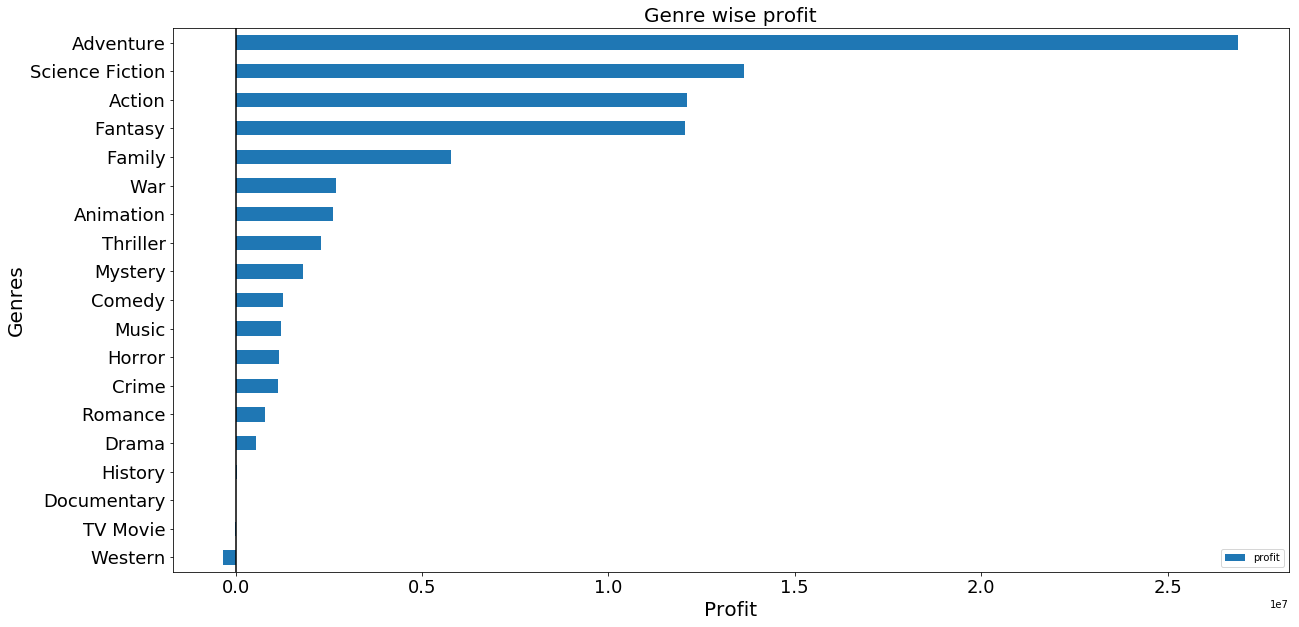

In [32]:
ax = mean_per_genre.sort_values('profit', ascending = False).plot(kind='barh', x='Genre',y='profit',figsize=(20, 10), legend=True, fontsize=18)
ax.set_title("Genre wise profit",fontsize=20)
ax.set_xlabel("Profit", fontsize=20)
ax.set_ylabel("Genres", fontsize=20)
ax.axvline(x=-1, color='black')

# invert for largest on top 
ax.invert_yaxis()
plt.show()

The above bar graph shows that highest profit is generated by Adventure genre followed by Science Fiction and Action. Although Drama is the most common genre, the profit generated by it is very low.

Sorting by votes_average and analysing top 5 geners

In [33]:
mean_per_genre.sort_values('mean_votes_average', ascending=False).head()

,Genre,mean_votes_average,mean_budget,mean_revenue,profit
3,TV Movie,4.857759,1.014943e+04,0.000000e+00,-1.014943e+04
10,Action,3.605734,4.772743e+06,1.688099e+07,1.210824e+07
11,Thriller,3.593819,1.672841e+06,3.970002e+06,2.297161e+06
8,Adventure,3.586571,1.148844e+07,3.837496e+07,2.688652e+07
16,History,3.542857,1.480812e+06,1.518112e+06,3.729962e+04


Sorting by budget and analysing top 5 geners

In [34]:
mean_per_genre.sort_values('mean_budget', ascending=False).head()

,Genre,mean_votes_average,mean_budget,mean_revenue,profit
8,Adventure,3.586571,1.148844e+07,3.837496e+07,2.688652e+07
13,Science Fiction,3.155288,5.818171e+06,1.944660e+07,1.362843e+07
14,Fantasy,3.006496,5.349951e+06,1.739134e+07,1.204139e+07
10,Action,3.605734,4.772743e+06,1.688099e+07,1.210824e+07
4,Family,3.139613,3.532012e+06,9.309794e+06,5.777782e+06


Sorting by revenue and analysing top 5 geners

In [35]:
mean_per_genre.sort_values('mean_revenue', ascending=False).head()

,Genre,mean_votes_average,mean_budget,mean_revenue,profit
8,Adventure,3.586571,1.148844e+07,3.837496e+07,2.688652e+07
13,Science Fiction,3.155288,5.818171e+06,1.944660e+07,1.362843e+07
14,Fantasy,3.006496,5.349951e+06,1.739134e+07,1.204139e+07
10,Action,3.605734,4.772743e+06,1.688099e+07,1.210824e+07
4,Family,3.139613,3.532012e+06,9.309794e+06,5.777782e+06


Sorting by profit and analysing top 5 geners

In [36]:
mean_per_genre.sort_values('profit', ascending=False).head()

,Genre,mean_votes_average,mean_budget,mean_revenue,profit
8,Adventure,3.586571,1.148844e+07,3.837496e+07,2.688652e+07
13,Science Fiction,3.155288,5.818171e+06,1.944660e+07,1.362843e+07
10,Action,3.605734,4.772743e+06,1.688099e+07,1.210824e+07
14,Fantasy,3.006496,5.349951e+06,1.739134e+07,1.204139e+07
4,Family,3.139613,3.532012e+06,9.309794e+06,5.777782e+06


It's very interesting to see that the top 5 highest vote average consists of Adventure, Science Fiction,Action, Fantasy, Family while none of these genres are in either one of the other three categories, which all have the same top 3: Adventure, Science Fiction,Action. This is easily explained, since budget and revenue should be closely related and profit is directly derived from budget and revenue. However, we would have expected a higher correlation between the budget and the quality of a movie.

##### Number of movies in each month

In [37]:
nom = tmdb_movies_data[['release_year']].loc[tmdb_movies_data['release_year'].isin([2018])].groupby(tmdb_movies_data['release_month']).count()

nom = nom.reset_index()
nom.rename(columns ={'release_year':'count'}, inplace = True)
nom['release_month'] = pd.to_numeric(nom['release_month'], downcast='integer')
nom['release_month'] = nom['release_month'].apply(lambda x: calendar.month_abbr[x])
nom.reset_index(drop=True, inplace = True)

In [38]:
nom

,release_month,count
0,Jan,1760
1,Feb,1290
2,Mar,1744
3,Apr,1561
4,May,1594
5,Jun,1561
6,Jul,1128
7,Aug,1462
8,Sep,1620
9,Oct,1991


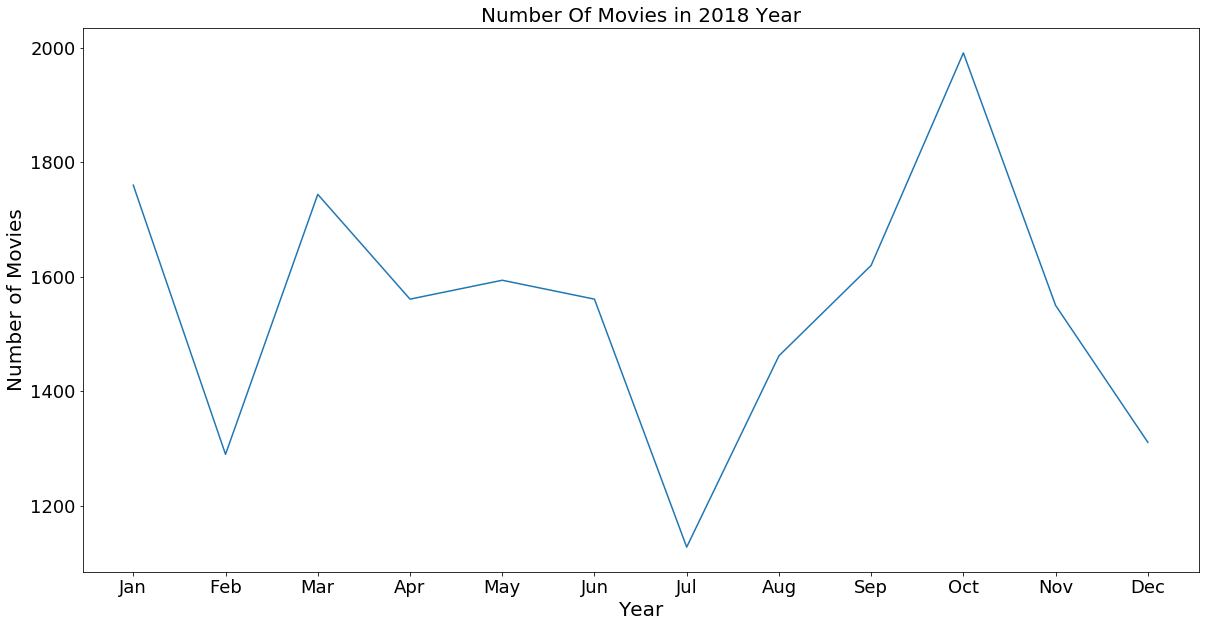

In [39]:
plt.figure(figsize=(20,10))
plt.title("Number Of Movies in 2018 Year",fontsize=20)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Number of Movies',fontsize=20)
plt.tick_params(labelsize=18)
plt.plot(nom['release_month'],nom['count'])
plt.show()

Above line graph shows the number of movies released in every month. It is seen that the highest number of movies were released in October whereas July had the lowest number of movies released.

##### Highest revenue movie and vote_average for the movies

In [40]:
df_popularity = tmdb_movies_data[['movie_title','revenue','vote_average']].sort_values(by=['revenue'], ascending=False).head(10)
df_popularity['revenue'] = df_popularity['revenue'].apply(millify)
df_popularity.reset_index(drop=True, inplace = True)
df_popularity

,movie_title,revenue,vote_average
0,Avengers: Infinity War,$2 B,8.3
1,Black Panther,$1 B,7.4
2,Jurassic World: Fallen Kingdom,$1 B,6.5
3,Incredibles 2,$1 B,7.6
4,Aquaman,$1 B,6.8
5,Venom,$855 M,6.6
6,Bohemian Rhapsody,$835 M,8.1
7,Mission: Impossible - Fallout,$791 M,7.3
8,Captain Marvel,$779 M,7.3
9,Deadpool 2,$742 M,7.5


The table shows movies with highest revenues and their vote averages. Avengers: Infinity War is the movie with highest revenue at $2 billion and has a vote average of 8.3.

##### Revenue and budget tradeoff

In [41]:
size = tmdb_movies_data['revenue']

hover_text = []

for index, row in tmdb_movies_data.iterrows():
    hover_text.append(('Title: {title}<br>'+
                      'Budget: {budget}<br>'+
                      'Revenue: {revenue}<br>').format(title=row['movie_title'],budget=str(millify(row['budget'])),revenue=str(millify(row['revenue']))))

trace0 = go.Scatter(
    x = tmdb_movies_data['budget'],
    y = tmdb_movies_data['revenue'],
    text = hover_text,
    mode='markers',
    hoverinfo = 'text',
    name = 'Entire Data',
    marker=dict(
        size=size,
        sizemode='area',
        sizeref=2.*max(size)/(40.**2),
        sizemin=4,
        color = tmdb_movies_data['revenue'], 
        showscale = True
        
    )
)


layout = go.Layout(
    title='Revenue vs Budget',
    xaxis=dict(
        title='Budget',
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
    yaxis=dict(
        title='Revenue',
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
   showlegend=False
)
data = [trace0]
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='bubblechart-size-ref')

The scatter plot for Revenue vs Budget again shows that 'Avengers: Infinity War' is the movie with highest revenue and a budget of $ \$ $300 million. There is a movie 'Sketching for Sweetheart' which has the highest budget at $ \$ $944 million but did not generate that much revenue.

##### Revenue and runtime tradeoff

In [42]:
size = tmdb_movies_data[((tmdb_movies_data['runtime']<200) | (tmdb_movies_data['runtime'] > 60))&(tmdb_movies_data['revenue'] != 0)]['revenue']

hover_text = []

for index, row in tmdb_movies_data[((tmdb_movies_data['runtime']<200) | (tmdb_movies_data['runtime'] > 60))&(tmdb_movies_data['revenue'] != 0)].iterrows():
    hover_text.append(('Title: {title}<br>'+
                      'Runtime: {budget}<br>'+
                      'Revenue: {revenue}<br>').format(title=row['movie_title'],budget=row['runtime'],revenue=str(millify(row['revenue']))))

trace0 = go.Scatter(
    x = tmdb_movies_data[((tmdb_movies_data['runtime']<200) | (tmdb_movies_data['runtime'] > 60))&(tmdb_movies_data['revenue'] != 0)]['runtime'],
    y = tmdb_movies_data[((tmdb_movies_data['runtime']<200) | (tmdb_movies_data['runtime'] > 60))&(tmdb_movies_data['revenue'] != 0)]['revenue'],
    text = hover_text,
    mode='markers',
    hoverinfo = 'text',
    name = 'Entire Data',
    marker=dict(
        size=size,
        sizemode='area',
        sizeref=2.*max(size)/(40.**2),
        sizemin=4,
        color = tmdb_movies_data[((tmdb_movies_data['runtime']<200) | (tmdb_movies_data['runtime'] > 60))&(tmdb_movies_data['revenue'] != 0)]['revenue'], 
        showscale = True
        
    )
)


layout = go.Layout(
    title='Revenue vs Runtime',
    xaxis=dict(
        title='Runtime',
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
    yaxis=dict(
        title='Revenue',
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
   showlegend=False
)
data = [trace0]
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='bubblechart-size-ref')

The scatter plot for revenue vs runtime shows that runtime does not affect the revenue generated by a movie. Some movies have bigger runtime and lesser revenue while some have lesser runtime and larger revenue. 

### Conclusion

The analysis of countries, language, genres, revenue, budget and profits shows us the following key points:
1. Top 3 countries which produce Highest number of movies are United States of America, United Kingdom and India. 

2. Most movies are made in English language.

3. ‘How to Train your Dragon: The Hidden World’ is the most popular movie of 2018.

4. ‘How to Train your Dragon: The Hidden World’, ‘Fantastic Beasts: The Crimes of Grindelwald’ and ‘Silukkuvarupatti Singam’ are the most popular movies in the top 3 countries with most movie productions namely, United States of America, United Kingdom and India respectively. 

5. Drama is the most common genre in TMDb database as well as in the top 3 countries followed by Documentary and Comedy.

6. Although Drama is the most common genre, highest profit is generated in Adventure movies. Which says that people love Adventures movies more then drama.

7. While Action movies have the highest mean votes average, Adventure movies have the highest mean budget, highest mean revenue and highest profit. 

8. Highest number of movies are released in the month of October and lowest in July. 

9. ‘Avengers: Infinity War’ is the movie with the highest revenue and highest vote average.

10. Revenue and Budget tradeoff and Revenue and Runtime tradeoff shows that neither budget nor runtime can decide if the revenue of the movie will be high or low. 
